In [59]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
from stable_baselines3 import PPO, SAC
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor

import neptune
from sec.keys import NEPTUNE_API_TOKEN
from src.environment.components.adaptive_consumption import AdaptiveConsumptionParameters
from src.environment.components.battery import BatteryParameters
from src.environment.components.tcl import TCLParameters
from visualization import visualize_battery_behaviour, visualize_scenario, visualize_reward

In [61]:
class LoggingCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.infos = []

    def _on_step(self) -> bool:
        self.infos.append(self.locals["info"])
        return True

    def __call__(self, locals_, globals_):
        self.locals = locals_
        self.globals = globals_
        self._on_step()

In [62]:
run = neptune.init_run(project="timwalter/smart-energy-controller", api_token=NEPTUNE_API_TOKEN, 
                       source_files=[
                           "src/environment/single_family_home.py", 
                           "src/environment/components/adaptive_consumption.py", 
                           "src/environment/components/battery.py", 
                           "src/environment/components/tcl.py", 
                           "src/environment/components/base/data_loader.py",
                           ])    

https://app.neptune.ai/timwalter/smart-energy-controller/e/SMAR-10


In [63]:
name = "ppo_battery_only_synthetic_10eps"
parameter = {
    "env/parameters/adaptive_consumption": False,
    "env/parameters/battery": True,
    "env/parameters/tcl": False,
    "env/parameters/data": "synthetic",
    "env/parameters/episode_length": 100,
    "model/parameters/epochs": 10,
    "model/parameters/algorithm": "SAC",
}

In [64]:
run["parameters"] = parameter

In [65]:
from src.environment.single_family_home import SingleFamilyHome
env = Monitor(SingleFamilyHome(
    adaptive_consumption_params=AdaptiveConsumptionParameters() if parameter["env/parameters/adaptive_consumption"] else None,
    battery_params=BatteryParameters() if parameter["env/parameters/battery"] else None,
    tcl_params=TCLParameters() if parameter["env/parameters/tcl"] else None,
    synthetic_data=parameter["env/parameters/data"] == "synthetic",
    episode_length=parameter["env/parameters/episode_length"],
))

In [66]:
check_env(env, warn=True)

In [67]:
model = SAC("MultiInputPolicy", env, tensorboard_log="./tensorboard/")

In [68]:
untrained_callback = LoggingCallback()
untrained_mean_reward, untrained_std_reward = evaluate_policy(model, env, n_eval_episodes=1, callback=untrained_callback)

In [69]:
model = model.learn(total_timesteps=len(env.unwrapped.electricity_grid.episode)*parameter["model/parameters/epochs"])

In [70]:
trained_callback = LoggingCallback()
trained_mean_reward, trained_std_reward = evaluate_policy(model, env, n_eval_episodes=1, callback=trained_callback)


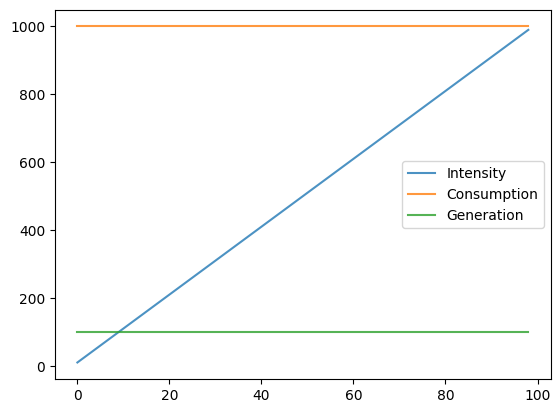

In [71]:
visualize_scenario(untrained_callback)

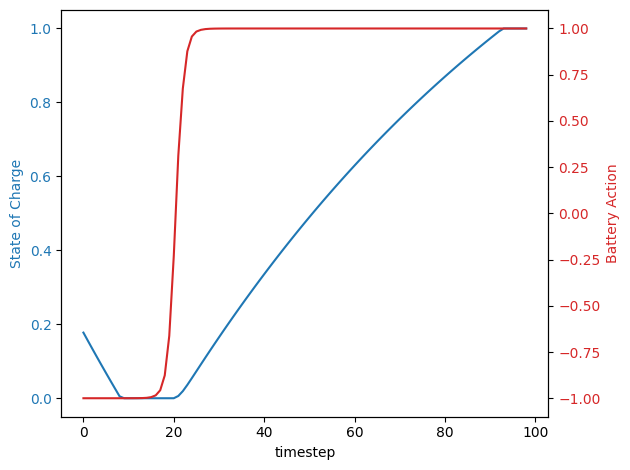

In [72]:
visualize_battery_behaviour(untrained_callback, env)

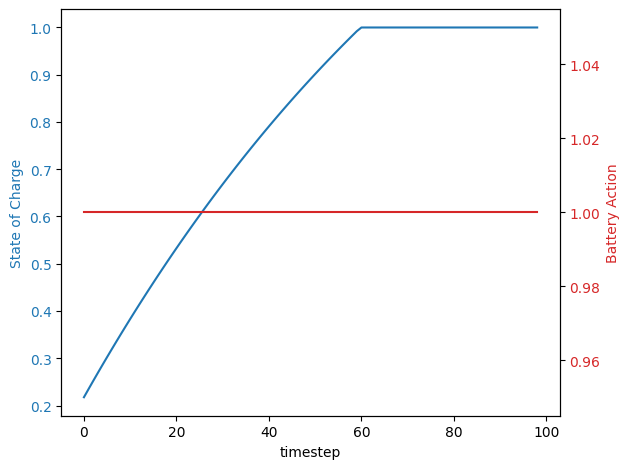

In [73]:
visualize_battery_behaviour(trained_callback, env)

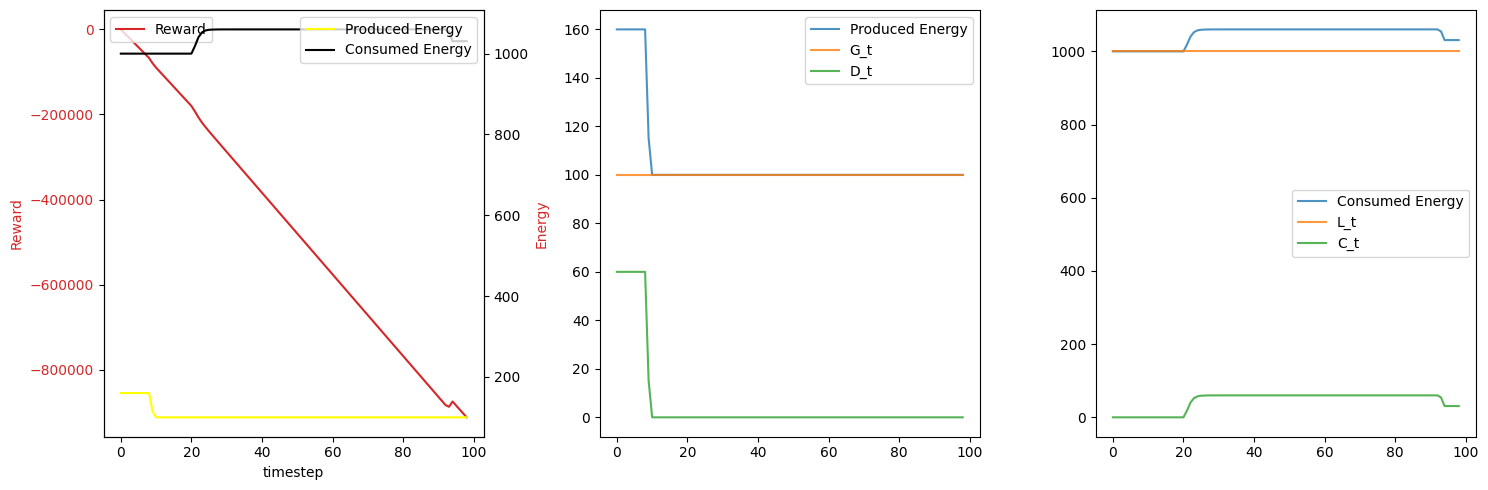

In [74]:
visualize_reward(untrained_callback)

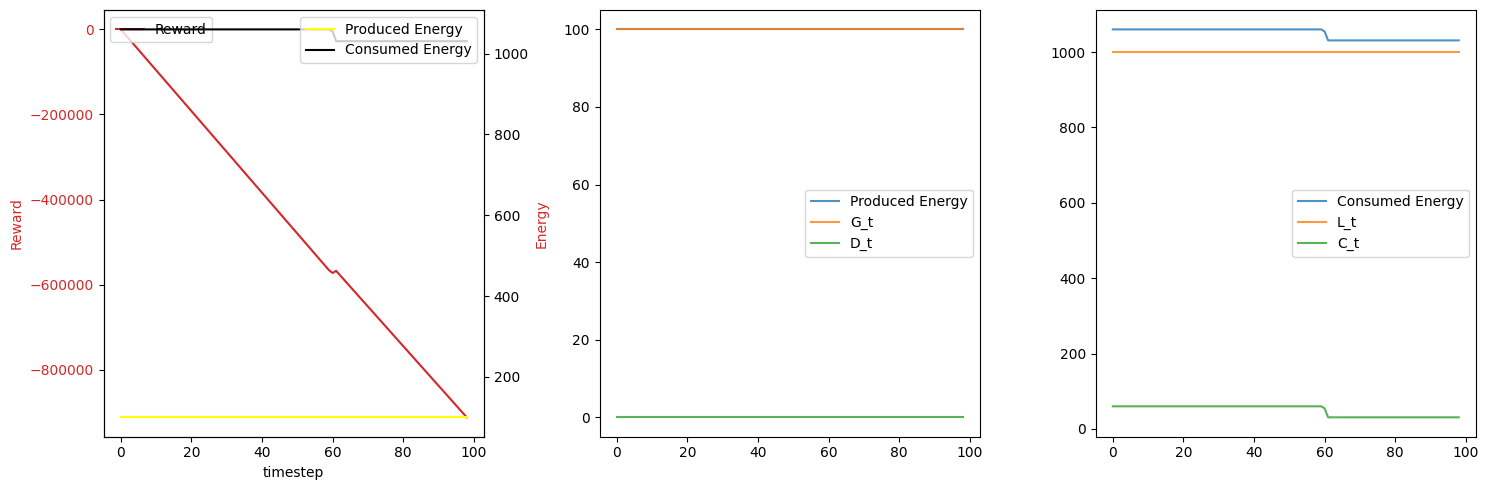

In [75]:
visualize_reward(trained_callback)

In [76]:
model.save(f"models/{name}")
run.stop()

Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/timwalter/smart-energy-controller/e/SMAR-10/metadata
